# Task 3: Pre-trained Transformers

## Imports

In [196]:
from datasets import load_dataset
import utils.task3_baseline_utils as base_utils
import random
import numpy as np
import pandas as pd
import torch

%load_ext autoreload
%autoreload 2

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%reload_ext autoreload

## Load Dataset

In [197]:
dataset = load_dataset("argilla/medical-domain", split="train")

print("Features available:")
print(dataset.column_names)
print("\nFormat of 'prediction' column:")
print(dataset.features['prediction'])
print("\nDataset length: ", len(dataset))

Features available:
['text', 'inputs', 'prediction', 'prediction_agent', 'annotation', 'annotation_agent', 'multi_label', 'explanation', 'id', 'metadata', 'status', 'event_timestamp', 'metrics']

Format of 'prediction' column:
List({'label': Value('string'), 'score': Value('float64')})

Dataset length:  4966


In [198]:
dataset_df = dataset.to_pandas()

View labels and imbalance

In [199]:
labels = [x[0]['label'] for x in dataset_df.loc[:,"prediction"]]
labels = [x[1:] for x in labels] # remove whitespace before the label
unique_labels = list(sorted(set(labels)))
label_counts = {}
for l in labels:
	if l not in label_counts.keys():
		label_counts[l] = 0
	label_counts[l] += 1
	
print(" Unique labels and counts: ".center(50, '-'))
for l in unique_labels:
	print(l, label_counts[l])

----------- Unique labels and counts: ------------
Allergy / Immunology 7
Autopsy 8
Bariatrics 18
Cardiovascular / Pulmonary 371
Chiropractic 14
Consult - History and Phy. 516
Cosmetic / Plastic Surgery 27
Dentistry 27
Dermatology 29
Diets and Nutritions 10
Discharge Summary 108
ENT - Otolaryngology 96
Emergency Room Reports 75
Endocrinology 19
Gastroenterology 224
General Medicine 259
Hematology - Oncology 90
Hospice - Palliative Care 6
IME-QME-Work Comp etc. 16
Lab Medicine - Pathology 8
Letters 23
Nephrology 81
Neurology 223
Neurosurgery 94
Obstetrics / Gynecology 155
Office Notes 50
Ophthalmology 83
Orthopedic 355
Pain Management 61
Pediatrics - Neonatal 70
Physical Medicine - Rehab 21
Podiatry 47
Psychiatry / Psychology 53
Radiology 273
Rheumatology 10
SOAP / Chart / Progress Notes 166
Sleep Medicine 20
Speech - Language 9
Surgery 1088
Urology 156


## Text-Length Based Filtering

Some samples contain extremely short texts (e.g. a few characters), which are
unlikely to be informative for document-level classification.

We remove samples with fewer than 40 characters **before** splitting the data,
and report how many samples are filtered out.


In [200]:
# Minimum character threshold
MIN_CHARS = 40

initial_len = len(dataset_df)

short_text_idx = [
	i for i, t in enumerate(dataset_df["text"])
	if len(str(t)) < MIN_CHARS
]

dataset_df = dataset_df.drop(index=short_text_idx).reset_index(drop=True)

removed_len = len(short_text_idx)
final_len = len(dataset_df)

print(f"Initial dataset size : {initial_len}")
print(f"Removed samples      : {removed_len}")
print(f"Removed ratio        : {removed_len / initial_len:.2%}")
print(f"Final dataset size   : {final_len}")


Initial dataset size : 4966
Removed samples      : 16
Removed ratio        : 0.32%
Final dataset size   : 4950


## Stratified Train/Test Split

- To ensure a fair evaluation under severe class imbalance, we use a
**stratified** train/test split. 

- This preserves the label distribution
across splits and is required for reliable macro-F1 evaluation.


In [206]:
from sklearn.model_selection import train_test_split

texts = dataset_df["text"].tolist()
labels = [x[0]["label"] for x in dataset_df["prediction"]]

split = 0.7
test_size = 1 - split
train_texts, test_texts, train_labels, test_labels = train_test_split(
	texts,
	labels,
	test_size=test_size,
	stratify=labels,
	random_state=42
)

print(f"Train/test split: {split}, {round(1-split,1)}")
print("Train set length:", len(train_texts))
print("Test set length :", len(test_texts))


Train/test split: 0.7, 0.3
Train set length: 3464
Test set length : 1486


# [Subtask 1]: Baseline

Build and tune a strong classical baseline appropriate to the task (e.g., TF IDF + Logistic Regression / Linear SVM or XGBoost for classification/NER). Record metrics as the anchor row of a single results table.


This subtask implements a reproducible TF-IDF + linear baseline with:
- stratified train/test split (already done- same data set also used for subtask 2 and 3)
- configurable text preprocessing
- shared feature space across ML models

## 1.1 Text Preprocessing + Tokenization + Classification


### Generate Medical Boilerplate Stopwords for Optional Use

- Apply solely on the specific trainset to avoid information leakage in test set. 

In [202]:
from utils.preprocessing_enhanced import get_specific_stopwords
import os

# Extract candidate capitalized phrases from training data only
capital_phrases = get_specific_stopwords(
	pd.DataFrame({"text": train_texts}),
	min_stopword_len=6
)

# Count phrase frequencies
unique_terms, counts = np.unique(capital_phrases, return_counts=True)

phrase_stats = np.vstack((unique_terms, counts)).T
phrase_stats = phrase_stats[np.argsort(-counts.astype(int), kind="stable")]

# Inspect top phrases (optional)
for i in range(min(10, len(phrase_stats))):
	print(f"{i}. {phrase_stats[i, 0]}  (count={phrase_stats[i, 1]})")

# Frequency threshold for custom stopwords
MIN_STOPWORD_FREQUENCY = 30

custom_stopwords = phrase_stats[
	phrase_stats[:, 1].astype(int) >= MIN_STOPWORD_FREQUENCY
][:, 0]

# Save stopwords to CSV
STOPWORD_PATH = "./Task3/utils_files"
os.makedirs(STOPWORD_PATH, exist_ok=True)
STOPWORD_PATH = os.path.join(STOPWORD_PATH, "custom_stopwords.csv")

pd.DataFrame(custom_stopwords).to_csv(
	STOPWORD_PATH,
	sep=",",
	header=False,
	index=False
)

print(f"Saved {len(custom_stopwords)} custom stopwords to {STOPWORD_PATH}")


0. PROCEDURE  (count=921)
1. ANESTHESIA  (count=908)
2. PREOPERATIVE DIAGNOSIS  (count=818)
3. POSTOPERATIVE DIAGNOSIS  (count=757)
4. PHYSICAL EXAMINATION  (count=689)
5. IMPRESSION  (count=680)
6. HISTORY OF PRESENT ILLNESS  (count=647)
7. HEENT  (count=609)
8. ALLERGIES  (count=608)
9. PAST MEDICAL HISTORY  (count=578)
Saved 133 custom stopwords to ./Task3/utils_files\custom_stopwords.csv


### Selection of Processing Pipelines

In [203]:
from utils.preprocessing_enhanced import preprocess_text, load_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# configs
PROCESS_CONFIG_1 = {
	"enable": False,
}
PROCESS_CONFIG_2 = {
	"enable": True,
	"lowercase": True,  
	"lemmatize": False,  
}
PROCESS_CONFIG_3 = {
	"enable": True,
	"lowercase": True,  
	"lemmatize": True,  
}
PROCESS_CONFIG_4 = {
	"enable": True,
	"lowercase": True,  
	"lemmatize": False,  
	"remove_stopwords": True,  #  
}

PROCESS_CONFIGS = [
	PROCESS_CONFIG_1,
	PROCESS_CONFIG_2,
	PROCESS_CONFIG_3,
	PROCESS_CONFIG_4,
]

CUSTOM_STOPWORDS = load_stopwords(STOPWORD_PATH)

X_cache = {}

tfidf = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75,min_df=5, use_idf=True, smooth_idf=True,sublinear_tf=True, max_features=1000)



for idx, config in enumerate(PROCESS_CONFIGS, start=1):

	print(f"Running PROCESS_CONFIG_{idx}: {config}")

	# ---------- Text preprocessing ----------
	train_texts_proc = pd.Series(train_texts).apply(
		lambda x: preprocess_text(
			x,
			custom_stopwords=CUSTOM_STOPWORDS,
			**config
		)
	)
	test_texts_proc = pd.Series(test_texts).apply(
		lambda x: preprocess_text(
			x,
			custom_stopwords=CUSTOM_STOPWORDS,
			**config
		)
	)
	

	X_train_proc = tfidf.fit_transform(train_texts_proc)
	X_test_proc  = tfidf.transform(test_texts_proc)

	# save cache for later use
	X_cache[idx] = {
		"X_train": X_train_proc,
		"X_test": X_test_proc,
	}

	# ---------- Logistic Regression ----------
	lr = LogisticRegression(
		max_iter=1000,
		n_jobs=-1,
		class_weight="balanced"
	)

	lr.fit(X_train_proc, train_labels)
	preds = lr.predict(X_test_proc)

	# ---------- Save results ----------
	output_path = f"Task3/results/logistic_regression{idx}.csv"

	base_utils.store_model_metrics_manual(
		test_labels,
		preds,
		output_path
	)
	print(f"Saved results to {output_path}\n")


[preprocessing] Loaded 133 stopwords from ./Task3/utils_files\custom_stopwords.csv
Running PROCESS_CONFIG_1: {'enable': False}
Saved results to Task3/results/logistic_regression1.csv

Running PROCESS_CONFIG_2: {'enable': True, 'lowercase': True, 'lemmatize': False}
Saved results to Task3/results/logistic_regression2.csv

Running PROCESS_CONFIG_3: {'enable': True, 'lowercase': True, 'lemmatize': True}


KeyboardInterrupt: 

In [ ]:
import pandas as pd

RESULT_PATHS = {
	"LR + raw": "Task3/results/logistic_regression1.csv",
	"LR + lowercase": "Task3/results/logistic_regression2.csv",
	"LR + lower+lemm": "Task3/results/logistic_regression3.csv",
	"LR + lower+stopword": "Task3/results/logistic_regression4.csv",
}

rows = []
for model_name, path in RESULT_PATHS.items():
	df = pd.read_csv(path)
	df["model"] = model_name
	rows.append(df)

summary_df = pd.concat(rows, ignore_index=True).set_index("model")

summary_df

,f1_weighted,accuracy,precision,recall,f1_macro
model,,,,,
LR + raw,0.304909,0.350606,0.366863,0.350606,0.407846
LR + lowercase,0.306662,0.352624,0.368757,0.352624,0.409055
LR + lower+lemm,0.304990,0.351952,0.366790,0.351952,0.407849
LR + lower+stopword,0.307340,0.353297,0.367273,0.353297,0.407856


- Lowercasing slightly improves macro-F1, while adding stopword removal increases weighted F1 at the cost of macro-F1.

- Since macro-F1 equally weights all classes and better reflects minority-class performance, we can select LR + lowercase as the primary text preprocessing pipeline.

## 1.2 Linear Baseline Models Selection

In [204]:
## Load the selected Vectors
X_train_proc= X_cache[2]["X_train"]
X_test_proc= X_cache[2]["X_test"]



### Logistic Regression 

In [228]:
from sklearn.linear_model import LogisticRegression
import utils.task3_baseline_utils as base_utils


lr = LogisticRegression(
	max_iter=1000,
	n_jobs=-1,
	class_weight="balanced"
)

lr.fit(X_train_proc, train_labels)
preds = lr.predict(X_test_proc)

base_utils.store_model_metrics_manual(
	test_labels,
	preds,
	"Task3/results/logistic_regression.csv"
)


### Linear SVM

In [229]:
from sklearn.svm import LinearSVC

svm = LinearSVC(
	C=0.01,
	class_weight="balanced"
)

svm.fit(X_train_proc, train_labels)
preds = svm.predict(X_test_proc)

base_utils.store_model_metrics_manual(
	test_labels,
	preds,
	"Task3/results/linear_svm.csv"
)

### SGD Classifier

In [230]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(
	loss="hinge",
	alpha=1e-2,
	max_iter=1000,
	class_weight="balanced"
)

sgd.fit(X_train_proc, train_labels)
preds = sgd.predict(X_test_proc)

base_utils.store_model_metrics_manual(
	test_labels,
	preds,
	"Task3/results/sgd.csv"
)


### Multinomial NB Classifier


In [231]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(
	alpha=0.1  # Laplace smoothing, default is fine
)

nb.fit(X_train_proc, train_labels)
preds = nb.predict(X_test_proc)

base_utils.store_model_metrics_manual(
	test_labels,
	preds,
	"Task3/results/naive_bayes.csv"
)



## 1.4 Baseline Anchor Summary

In [232]:
import pandas as pd

RESULT_PATHS = {
	"LR": "Task3/results/logistic_regression.csv",
	"Linear SVM": "Task3/results/linear_svm.csv",
	"SGD-SVM": "Task3/results/sgd.csv",
	"Naive_Bayes": "Task3/results/naive_bayes.csv",

}

rows = []
for model_name, path in RESULT_PATHS.items():
	df = pd.read_csv(path)
	df["model"] = model_name
	rows.append(df)

summary_df = pd.concat(rows, ignore_index=True).set_index("model")

def highlight_max(s):
	is_max = s == s.max()
	return ['font-weight: bold' if v else '' for v in is_max]

summary_df.style.apply(highlight_max, axis=0)


,f1_weighted,accuracy,precision,recall,f1_macro
model,,,,,
LR,0.306662,0.352624,0.368757,0.352624,0.409055
Linear SVM,0.312957,0.334455,0.382745,0.334455,0.342539
SGD-SVM,0.248491,0.277927,0.328532,0.277927,0.283017
Naive_Bayes,0.346255,0.379542,0.363805,0.379542,0.252265


### Brief Summary of SubTask 1:

- Logistic Regression achieves the highest macro-F1, showing superior balance across minority classes.

- Naive_Bayes offers the best weighted-F1 accuracy and recall, reflecting strong performance on frequent classes

TF-IDF + Logistic Regression achieves the highest macro-F1, making it the **most balanced** baseline; we therefore use it as the anchor model for comparison with transformer-based approaches.

# [Subtask 2]: Encoder track. 

Evaluate (a) an out-of-the-box encoder with frozen features + linear head (no encoder training), 

then (b) supervised fine-tuning (SFT) or continual pre-training (CPT) of a base BERT with the same task head. Record both results in one table.

- The data split and preprocessing are fixed same as SubTask 1.
- Macro-F1 is the primary metric.
- Weighted Entropy Loss is used in training to overcome data imbalance.
	+ $w_i  \propto 1/\sqrt{n_i}$ instead of $w_i  \propto 1/n_i$ is used for SFT training for numerical stability. 
	+ Frozen Encoder favors $w_i  \propto 1/n_i$ rather than $w_i  \propto 1/\sqrt{n_i}$ in terms of macro-F1.
- CPT of Encoder is followed by a linear head.


In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
import utils.task3_baseline_utils as base_utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


### Label Loading (Shared)

In [ ]:
# train_labels / test_labels are string labels from the stratified split

label_encoder = LabelEncoder()
train_labels_enc = label_encoder.fit_transform(train_labels)
test_labels_enc  = label_encoder.transform(test_labels)

num_labels = len(label_encoder.classes_)

DEVICE = "cuda"
# Compute class weights from training labels (for imbalanced data)
class_counts = np.bincount(train_labels_enc)
class_weights = 1.0 / class_counts   # 1/ni may be more agressive
class_weights_sqrt = 1.0 / np.sqrt(class_counts)   # 1/sqrt(ki) may be less agressive
class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
class_weights_sqrt = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)


print("Num of labels:", num_labels)
print(test_labels_enc[0], test_labels[0])

Num of labels: 40
21  Nephrology


/tmp/ipykernel_246336/2276401393.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights_sqrt = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)


### Dataset Preparation

In [ ]:
# -------------------------
# Dataset + DataLoaders
# -------------------------

# Sample both head and tail for long texts
def encode_head_tail(tokens, max_len):
	if len(tokens) <= max_len:
		return tokens
	half = max_len // 2
	return tokens[:half] + tokens[-half:]


class TextDataset(Dataset):
	def __init__(self, texts, labels_enc, tokenizer, max_len=512):
		self.texts = texts
		self.labels = labels_enc
		self.tokenizer = tokenizer
		self.max_len = max_len

	def __len__(self):
		return len(self.texts)

	def __getitem__(self, idx):
		text = self.texts[idx]

		# 1) Tokenize to tokens (NOT ids yet)
		tokens = self.tokenizer.tokenize(text)
		# 2) Apply head-tail sampling if needed
		tokens = encode_head_tail(tokens, self.max_len - 2)   # -2 to leave space for [CLS] and [SEP]
		# 3) Add special tokens
		tokens = [self.tokenizer.cls_token] + tokens + [self.tokenizer.sep_token]
		# 4) Convert tokens to ids
		input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
		# 5) Build attention mask
		attention_mask = [1] * len(input_ids)
		# 6) Pad to max_len
		pad_len = self.max_len - len(input_ids)
		if pad_len > 0:
			input_ids += [self.tokenizer.pad_token_id] * pad_len
			attention_mask += [0] * pad_len

		return {
			"input_ids": torch.tensor(input_ids, dtype=torch.long),
			"attention_mask": torch.tensor(attention_mask, dtype=torch.long),
			"labels": torch.tensor(self.labels[idx], dtype=torch.long),
		}


### Model (Encoder + Linear Head)

In [ ]:
# -------------------------
# 2) Encoder + Linear Head
# -------------------------
class EncoderClassifier(nn.Module):
	def __init__(self, encoder, num_labels):
		super().__init__()
		self.encoder = encoder
		self.classifier = nn.Linear(encoder.config.hidden_size, num_labels)

	def forward(self, input_ids, attention_mask):
		# Forward through encoder, take [CLS] token representation
		out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
		cls_emb = out.last_hidden_state[:, 0]  # [CLS]
		logits = self.classifier(cls_emb)
		return logits


### Trainer and Evaluator

In [ ]:
# Predict once
def get_predictions(model, loader, device="cuda"):
	model.eval()
	preds = []

	with torch.no_grad():
		for batch in loader:
			logits = model(
				batch["input_ids"].to(device),
				batch["attention_mask"].to(device),
			)
			preds.extend(torch.argmax(logits, dim=1).cpu().numpy())

	return preds


In [ ]:
# -------------------------
# Run one episode
# -------------------------
def run_one_setting(
	model,
	train_loader,
	epochs,
	lr,
	device="cuda",
	weight=class_weights,
):
	model.to(device)

	loss_fn = nn.CrossEntropyLoss(weight=weight)
	optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

	train_losses = []

	model.train()
	for ep in range(epochs):
		total_loss = 0.0

		for batch in train_loader:
			optimizer.zero_grad()

			logits = model(
				batch["input_ids"].to(device),
				batch["attention_mask"].to(device),
			)
			loss = loss_fn(logits, batch["labels"].to(device))
			loss.backward()
			optimizer.step()

			total_loss += loss.item()

		avg_loss = total_loss / len(train_loader)
		train_losses.append(avg_loss)

		print(
			f"[TRAIN] Epoch {ep+1}/{epochs} | loss = {avg_loss:.4f}"
		)

	return train_losses




### Training and Evaluation  

Two types of weights are evaluated.

* 1- Cross Entropy weighted by $w_i  \propto 1/n_i$ - More agreesive. 
* 2- Cross Entropy weighted by $w_i  \propto 1/\sqrt{n_i}$ - Less agreesive. 

In [ ]:
## Less Agressive Wegihts

from utils.task3_baseline_utils import store_model_metrics_manual
# -------------------------
# Loop over encoders
# -------------------------

ENCODERS = {
	"BioClinicalBERT": "emilyalsentzer/Bio_ClinicalBERT",
	"PubMedBERT": "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract",
	
} # Add more if needed:     "BERT-base": "bert-base-uncased", ...

DEVICE = "cuda"
MAX_LEN = 512
BATCH_TRAIN = 16 # 
BATCH_EVAL = 16

# Use raw text for more semantic representation
train_text_list = train_texts
test_text_list  = test_texts
ALL_RESULTS = []
ALL_TRAIN_CURVES = {}

for enc_name, enc_id in ENCODERS.items():
	print("\n" + "=" * 80)
	print(f"Encoder: {enc_name} with 1/sqrt(n) weighted loss")
	print("=" * 80)

	tokenizer = AutoTokenizer.from_pretrained(enc_id)
	encoder = AutoModel.from_pretrained(enc_id)

	# Freeze encoder
	for p in encoder.parameters():
		p.requires_grad = False

	model = EncoderClassifier(encoder, num_labels)

	train_ds = TextDataset(train_text_list, train_labels_enc, tokenizer, MAX_LEN)
	test_ds  = TextDataset(test_text_list,  test_labels_enc,  tokenizer, MAX_LEN)

	train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True)
	test_loader  = DataLoader(test_ds,  batch_size=BATCH_EVAL,  shuffle=False)

	# -------- Train --------
	train_losses = run_one_setting(
		model=model,
		train_loader=train_loader,
		epochs=5,
		lr=1e-3, # Linear head updates can have larger lr
		device=DEVICE,
		weight=class_weights_sqrt,
	)

	ALL_TRAIN_CURVES[enc_name] = train_losses

	# -------- Test evaluation (THIS was the missing explicit block) --------
	preds = get_predictions(model, test_loader, device=DEVICE)
	pred_labels = label_encoder.inverse_transform(preds)

	results_path = f"Task3/results/subtask2_{enc_name}_frozen_sqrt.csv"

	base_utils.store_model_metrics_manual(
		y_true=test_labels,
		y_pred=pred_labels,
		results_path=results_path,
	)

	df = pd.read_csv(results_path)
	df["model"] = enc_name
	ALL_RESULTS.append(df)

	print(f"\n[TEST] {enc_name} metrics:")
	print(df)



Encoder: BioClinicalBERT with 1/sqrt(n) weighted loss
[TRAIN] Epoch 1/5 | loss = 3.2989
[TRAIN] Epoch 2/5 | loss = 2.7029
[TRAIN] Epoch 3/5 | loss = 2.3793
[TRAIN] Epoch 4/5 | loss = 2.1619
[TRAIN] Epoch 5/5 | loss = 2.0189

[TEST] BioClinicalBERT metrics:
   f1_weighted  accuracy  precision    recall  f1_macro            model
0     0.234745  0.276581   0.346473  0.276581  0.279637  BioClinicalBERT

Encoder: PubMedBERT with 1/sqrt(n) weighted loss


/storage/homefs/kw24z021/miniconda3/envs/task3-nlp/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[TRAIN] Epoch 1/5 | loss = 3.3445
[TRAIN] Epoch 2/5 | loss = 2.5025
[TRAIN] Epoch 3/5 | loss = 2.0833
[TRAIN] Epoch 4/5 | loss = 1.8137
[TRAIN] Epoch 5/5 | loss = 1.6876

[TEST] PubMedBERT metrics:
   f1_weighted  accuracy  precision    recall  f1_macro       model
0     0.259149  0.303499   0.373509  0.303499  0.319811  PubMedBERT


In [ ]:
## More Agressive Wegihts

from utils.task3_baseline_utils import store_model_metrics_manual
# -------------------------
# Loop over encoders
# -------------------------

ENCODERS = {
	"BioClinicalBERT": "emilyalsentzer/Bio_ClinicalBERT",
	"PubMedBERT": "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract",
	
} # Add more if needed:     "BERT-base": "bert-base-uncased", ...

DEVICE = "cuda"
MAX_LEN = 512
BATCH_TRAIN = 16 # 
BATCH_EVAL = 16

# Use raw text for more semantic representation
train_text_list = train_texts
test_text_list  = test_texts
ALL_RESULTS = []
ALL_TRAIN_CURVES = {}

for enc_name, enc_id in ENCODERS.items():
	print("\n" + "=" * 80)
	print(f"Encoder: {enc_name} with 1/n weighted loss")
	print("=" * 80)

	tokenizer = AutoTokenizer.from_pretrained(enc_id)
	encoder = AutoModel.from_pretrained(enc_id)

	# Freeze encoder
	for p in encoder.parameters():
		p.requires_grad = False

	model = EncoderClassifier(encoder, num_labels)

	# Tokenize by each Encoder
	train_ds = TextDataset(train_text_list, train_labels_enc, tokenizer, MAX_LEN)
	test_ds  = TextDataset(test_text_list,  test_labels_enc,  tokenizer, MAX_LEN)
	train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True)
	test_loader  = DataLoader(test_ds,  batch_size=BATCH_EVAL,  shuffle=False)

	# -------- Train --------
	train_losses = run_one_setting(
		model=model,
		train_loader=train_loader,
		epochs=5,
		lr=1e-3, # Linear head updates can have larger lr
		device=DEVICE,
		weight=class_weights,
	)

	ALL_TRAIN_CURVES[enc_name] = train_losses

	# -------- Test evaluation (THIS was the missing explicit block) --------
	preds = get_predictions(model, test_loader, device=DEVICE)
	pred_labels = label_encoder.inverse_transform(preds)

	results_path = f"Task3/results/subtask2_{enc_name}_frozen.csv"

	base_utils.store_model_metrics_manual(
		y_true=test_labels,
		y_pred=pred_labels,
		results_path=results_path,
	)

	df = pd.read_csv(results_path)
	df["model"] = enc_name
	ALL_RESULTS.append(df)

	print(f"\n[TEST] {enc_name} metrics:")
	print(df)



Encoder: BioClinicalBERT with 1/n weighted loss


/storage/homefs/kw24z021/miniconda3/envs/task3-nlp/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[TRAIN] Epoch 1/5 | loss = 3.3487
[TRAIN] Epoch 2/5 | loss = 2.6958
[TRAIN] Epoch 3/5 | loss = 2.3668
[TRAIN] Epoch 4/5 | loss = 2.1743
[TRAIN] Epoch 5/5 | loss = 2.0148

[TEST] BioClinicalBERT metrics:
   f1_weighted  accuracy  precision    recall  f1_macro            model
0     0.260154  0.298116   0.332039  0.298116  0.275624  BioClinicalBERT

Encoder: PubMedBERT with 1/n weighted loss


/storage/homefs/kw24z021/miniconda3/envs/task3-nlp/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[TRAIN] Epoch 1/5 | loss = 3.3770
[TRAIN] Epoch 2/5 | loss = 2.5146
[TRAIN] Epoch 3/5 | loss = 2.0808
[TRAIN] Epoch 4/5 | loss = 1.7907
[TRAIN] Epoch 5/5 | loss = 1.6352

[TEST] PubMedBERT metrics:
   f1_weighted  accuracy  precision    recall  f1_macro       model
0     0.295005  0.313594   0.378437  0.313594  0.327976  PubMedBERT


## (b) Encoder SFT

The interface above can be reused for LoRA-based fine-tuning by:
- injecting LoRA into `encoder`
- setting `freeze_encoder=False`
- reducing epochs (e.g. 3)

This ensures encoder selection precedes fine-tuning.

In [ ]:
# =========================
# Full SFT: Encoder + Linear Head
# =========================


# Run Full SFT for each encoder
ENCODERS = {
	"BioClinicalBERT": "emilyalsentzer/Bio_ClinicalBERT",
	"PubMedBERT": "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract",
	
} # Add more if needed:     "BERT-base": "bert-base-uncased", ...

DEVICE = "cuda"
MAX_LEN = 512
BATCH_TRAIN = 16 # 
BATCH_EVAL = 16

# Use raw text for more semantic representation
train_text_list = train_texts
test_text_list  = test_texts
ALL_RESULTS = []
ALL_TRAIN_CURVES = {}

for enc_name, enc_id in ENCODERS.items():
	print("\n" + "=" * 80)
	print(f"Full SFT Encoder: {enc_name}")
	print("=" * 80)

	tokenizer = AutoTokenizer.from_pretrained(enc_id)
	encoder = AutoModel.from_pretrained(enc_id)

	# IMPORTANT: Full fine-tuning (do NOT freeze encoder)
	for p in encoder.parameters():
		p.requires_grad = True

	model = EncoderClassifier(encoder, num_labels)

	# Tokenize by each Encoder
	train_ds = TextDataset(train_text_list, train_labels_enc, tokenizer, MAX_LEN)
	test_ds  = TextDataset(test_text_list,  test_labels_enc,  tokenizer, MAX_LEN)
	train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True)
	test_loader  = DataLoader(test_ds,  batch_size=BATCH_EVAL,  shuffle=False)

	# -------- Train (Full SFT) --------
	train_losses = run_one_setting(
		model=model,
		train_loader=train_loader,
		epochs=3,
		lr=1e-5,      # standard SFT LR
		device=DEVICE,
		weight=class_weights_sqrt,
	)

	ALL_TRAIN_CURVES[f"{enc_name}_SFT"] = train_losses

	# -------- Final test evaluation --------
	preds = get_predictions(model, test_loader, device=DEVICE)
	pred_labels = label_encoder.inverse_transform(preds)

	results_path = f"Task3/results/subtask2_{enc_name}_SFT.csv"

	base_utils.store_model_metrics_manual(
		y_true=test_labels,
		y_pred=pred_labels,
		results_path=results_path,
	)

	df = pd.read_csv(results_path)
	df["model"] = f"{enc_name}_SFT"
	ALL_RESULTS.append(df)

	print(f"\n[TEST] {enc_name} Full SFT metrics:")
	print(df)



Full SFT Encoder: BioClinicalBERT


/storage/homefs/kw24z021/miniconda3/envs/task3-nlp/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[TRAIN] Epoch 1/3 | loss = 3.4264
[TRAIN] Epoch 2/3 | loss = 2.6019
[TRAIN] Epoch 3/3 | loss = 1.8833

[TEST] BioClinicalBERT Full SFT metrics:
   f1_weighted  accuracy  precision    recall  f1_macro                model
0     0.280933  0.345895   0.404606  0.345895  0.342471  BioClinicalBERT_SFT

Full SFT Encoder: PubMedBERT


/storage/homefs/kw24z021/miniconda3/envs/task3-nlp/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[TRAIN] Epoch 1/3 | loss = 3.4678
[TRAIN] Epoch 2/3 | loss = 2.5266
[TRAIN] Epoch 3/3 | loss = 1.7318

[TEST] PubMedBERT Full SFT metrics:
   f1_weighted  accuracy  precision    recall  f1_macro           model
0     0.297582  0.370121   0.408609  0.370121  0.407413  PubMedBERT_SFT


## Continual PreTraining

###  PubMedBERT outperforms BioClinicalBERT in previous task, so it is chosen to be the CPT model.

In [ ]:
from torch.utils.data import Dataset
import torch

class MLMDataset(Dataset):
	def __init__(self, texts, tokenizer, max_len=512):
		self.texts = texts
		self.tokenizer = tokenizer
		self.max_len = max_len

	def __len__(self):
		return len(self.texts)

	def __getitem__(self, idx):
		enc = self.tokenizer(
			self.texts[idx],
			truncation=True,
			padding="max_length",
			max_length=self.max_len,
			return_tensors="pt"
		)
		return {
			"input_ids": enc["input_ids"].squeeze(0),
			"attention_mask": enc["attention_mask"].squeeze(0),
		}
from transformers import (
	AutoTokenizer,
	AutoModelForMaskedLM,
	DataCollatorForLanguageModeling
)
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm


In [23]:
# -------------------------
# Config
# -------------------------
ENCODER_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
DEVICE = "cuda"
MAX_LEN = 512
BATCH_SIZE = 8        # CPT requires high MEM
EPOCHS = 2            # Not too much
LR = 5e-5             # CPT LR smaller, safer
MLM_PROB = 0.15      


In [24]:
# -------------------------
# Load tokenizer & model (MLM head!)
# -------------------------
tokenizer = AutoTokenizer.from_pretrained(ENCODER_NAME)
model = AutoModelForMaskedLM.from_pretrained(ENCODER_NAME)
model.to(DEVICE)


/storage/homefs/kw24z021/miniconda3/envs/task3-nlp/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model 

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [ ]:
# -------------------------
# Dataset & DataLoader
# -------------------------

# MLM is self-supervised, and won't see the labels, so add also the test dataset
mlm_texts = train_text_list + test_text_list
mlm_dataset = MLMDataset(
	texts=mlm_texts,   # 
	tokenizer=tokenizer,
	max_len=MAX_LEN
)

data_collator = DataCollatorForLanguageModeling(
	tokenizer=tokenizer,
	mlm=True,
	mlm_probability=MLM_PROB
)

mlm_loader = DataLoader(
	mlm_dataset,
	batch_size=BATCH_SIZE,
	shuffle=True,
	collate_fn=data_collator
)


In [ ]:
# -------------------------
# Optimizer
# -------------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)


In [ ]:
# -------------------------
# CPT training loop
# -------------------------
model.train()

for epoch in range(EPOCHS):
	total_loss = 0.0

	for batch in tqdm(mlm_loader, desc=f"CPT Epoch {epoch+1}"):
		optimizer.zero_grad()

		batch = {k: v.to(DEVICE) for k, v in batch.items()}
		outputs = model(**batch)

		loss = outputs.loss
		loss.backward()
		optimizer.step()

		total_loss += loss.item()

	avg_loss = total_loss / len(mlm_loader)
	print(f"[CPT] Epoch {epoch+1}/{EPOCHS} | MLM loss = {avg_loss:.4f}")


CPT Epoch 1: 100%|██████████| 619/619 [01:18<00:00,  7.93it/s]


[CPT] Epoch 1/2 | MLM loss = 1.4246


CPT Epoch 2: 100%|██████████| 619/619 [01:17<00:00,  7.94it/s]

[CPT] Epoch 2/2 | MLM loss = 1.2408


In [28]:
import os
CPT_OUTPUT_DIR = "Task3/models/"
os.makedirs(CPT_OUTPUT_DIR, exist_ok=True)
CPT_OUTPUT_DIR = os.path.join(CPT_OUTPUT_DIR, "pubmedbert_cpt")

model.save_pretrained(CPT_OUTPUT_DIR)
tokenizer.save_pretrained(CPT_OUTPUT_DIR)




('Task3/models/pubmedbert_cpt/tokenizer_config.json',
 'Task3/models/pubmedbert_cpt/special_tokens_map.json',
 'Task3/models/pubmedbert_cpt/vocab.txt',
 'Task3/models/pubmedbert_cpt/added_tokens.json',
 'Task3/models/pubmedbert_cpt/tokenizer.json')

In [ ]:
# =========================
# CPT Evaluation Pipeline
# =========================
import os
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer

# -------------------------
# Paths
# -------------------------

CPT_MODEL_DIR = CPT_OUTPUT_DIR

RESULTS_PATH  = "Task3/results"
os.makedirs(RESULTS_PATH, exist_ok=True)
RESULTS_PATH = os.path.join(RESULTS_PATH, "pubmedbert_cpt.csv")



DEVICE = "cuda"

# -------------------------
# Load CPT encoder
# -------------------------
tokenizer = AutoTokenizer.from_pretrained(CPT_MODEL_DIR)
encoder = AutoModel.from_pretrained(CPT_MODEL_DIR)

# Freeze encoder
for p in encoder.parameters():
	p.requires_grad = False

# -------------------------
# Encoder + Linear Head
# -------------------------
class EncoderClassifier(nn.Module):
	def __init__(self, encoder, num_labels):
		super().__init__()
		self.encoder = encoder
		self.classifier = nn.Linear(
			encoder.config.hidden_size,
			num_labels
		)

	def forward(self, input_ids, attention_mask):
		outputs = self.encoder(
			input_ids=input_ids,
			attention_mask=attention_mask
		)
		cls_emb = outputs.last_hidden_state[:, 0]
		logits = self.classifier(cls_emb)
		return logits


model = EncoderClassifier(encoder, num_labels)
model.to(DEVICE)

# -------------------------
# DataLoaders (reuse Dataset)
# -------------------------
 
train_ds = TextDataset(train_text_list, train_labels_enc, tokenizer, MAX_LEN)
test_ds  = TextDataset(test_text_list,  test_labels_enc,  tokenizer, MAX_LEN)
train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_EVAL,  shuffle=False)

# -------------------------
# Loss & Optimizer
# -------------------------
loss_fn = nn.CrossEntropyLoss(weight=class_weights_sqrt)
optimizer = torch.optim.AdamW(
	model.parameters(),
	lr=1e-3  # head-only LR
)

# -------------------------
# Train Linear Head
# -------------------------
EPOCHS = 5
model.train()

for ep in range(EPOCHS):
	total_loss = 0.0

	for batch in train_loader:
		optimizer.zero_grad()

		logits = model(
			batch["input_ids"].to(DEVICE),
			batch["attention_mask"].to(DEVICE),
		)
		loss = loss_fn(
			logits,
			batch["labels"].to(DEVICE)
		)
		loss.backward()
		optimizer.step()

		total_loss += loss.item()

	print(
		f"[CPT Frozen] Epoch {ep+1}/{EPOCHS} | "
		f"train loss = {total_loss / len(train_loader):.4f}"
	)

# -------------------------
# Final Evaluation on Test
# -------------------------
model.eval()
preds = []

with torch.no_grad():
	for batch in test_loader:
		logits = model(
			batch["input_ids"].to(DEVICE),
			batch["attention_mask"].to(DEVICE),
		)
		preds.extend(
			torch.argmax(logits, dim=1).cpu().numpy()
		)

pred_labels = label_encoder.inverse_transform(preds)


Some weights of BertModel were not initialized from the model checkpoint at Task3/models/pubmedbert_cpt and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[CPT Frozen] Epoch 1/5 | train loss = 3.2245
[CPT Frozen] Epoch 2/5 | train loss = 2.2280
[CPT Frozen] Epoch 3/5 | train loss = 1.8224
[CPT Frozen] Epoch 4/5 | train loss = 1.5918
[CPT Frozen] Epoch 5/5 | train loss = 1.4544


In [ ]:
# Scoring
base_utils.store_model_metrics_manual(
	y_true=test_labels,
	y_pred=pred_labels,
	results_path=RESULTS_PATH
)

# -------------------------
# Print results
# -------------------------
df = pd.read_csv(RESULTS_PATH)
df["model"] = "PubMedBERT_CPT_Frozen"

print("\n[CPT Frozen Encoder] Test metrics:")
print(df)



[CPT Frozen Encoder] Test metrics:
   f1_weighted  accuracy  precision    recall  f1_macro                  model
0     0.318718  0.372813   0.398117  0.372813  0.362386  PubMedBERT_CPT_Frozen


## Summary of SubTask-2

In [ ]:
import pandas as pd

RESULT_PATHS = {
	# -------------------------
	# Classical baselines
	# -------------------------
	"BaseLR (TF-IDF)": "Task3/results/logistic_regression.csv",
	# -------------------------
	# Encoder baselines (Subtask 2)
	# -------------------------
	# "BioClinicalBERT (Frozen)": "Task3/results/subtask2_BioClinicalBERT_frozen.csv",
	# "BioClinicalBERT (SFT)": "Task3/results/subtask2_BioClinicalBERT_SFT.csv",
	"PubMedBERT (Frozen)": "Task3/results/subtask2_PubMedBERT_frozen.csv",
	"PubMedBERT (SFT)": "Task3/results/subtask2_PubMedBERT_SFT.csv",

	# -------------------------
	# CPT
	# -------------------------
	"PubMedBERT (CPT → Frozen)": "Task3/results/pubmedbert_cpt.csv",
}

rows = []

for model_name, path in RESULT_PATHS.items():
	df = pd.read_csv(path)
	df["model"] = model_name
	rows.append(df)

summary_subtask2 = (
	pd.concat(rows, ignore_index=True)
	  .set_index("model")
	  .sort_values("f1_macro", ascending=False)
)

def highlight_max(s):
	is_max = s == s.max()
	return ['font-weight: bold' if v else '' for v in is_max]

summary_subtask2.style.apply(highlight_max, axis=0)


,f1_weighted,accuracy,precision,recall,f1_macro
model,,,,,
BaseLR (TF-IDF),0.304909,0.350606,0.366863,0.350606,0.407846
PubMedBERT (SFT),0.297582,0.370121,0.408609,0.370121,0.407413
PubMedBERT (CPT → Frozen),0.318718,0.372813,0.398117,0.372813,0.362386
PubMedBERT (Frozen),0.295005,0.313594,0.378437,0.313594,0.327976


### Brief Conclusion of SubTask 2:

- TF-IDF + Logistic Regression achieves the highest macro-F1, indicating that the task is dominated by sparse lexical cues rather than dense semantic representations.

- Supervised fine-tuning improves frozen encoder's performance, but still fails to outperform classical baselines on minority classes.

- Continual pre-training stabilizes representations but does not alter the decision structure, suggesting that label overlap is the primary bottleneck.

# [Subtask 3]: Decoder track
Design considerations:

- Model Selection. The model selected was as in task 2, [**Mistral-7B-Instruct**](https://arxiv.org/pdf/2310.06825), since it's efficient, it doesn't require licensing and it's specially trained to follow instructions and surpassing LLama-2-13B-Chat.

- Constraints. 
	- At Inference, we employed **prefix-constrained decoding** to restrict generation to the predefined label ontology. This eliminated invalid or multi-label outputs while preserving the model’s decision process and avoiding establishing an explicit ontology map. Before this integration, the model would struggle aligning strictly to the labels provided. 
		- For instance, some of those examples of misalignments were: "Allergology / Immunology", where the closest label is " Allergy / Immunology", "Otolaryngology" for "ENT - Otolaryngology", " 1. Gynecology 2. Dermatology" for " Gynecology" or "Dermatology".
	- Greedy-aproach (num_beams=1) and do_sample=False, since the task in hand is a closed-set classification, where we want deterministic, fast and stable metrics.

- Optimization:


## a) Prompting

For five-shot prompting, we selected five prototypical training examples covering diverse medical specialties. Examples were chosen to be unambiguous and representative of their respective domains, rather than reflecting label frequency. The same fixed set of examples was used for all test instances to ensure fair and reproducible evaluation. The selected labels were the following: **Ophthalmology**, **Psychiatry / Psychology**, **Podiatry**, **ENT - Otolaryngology**, **Obstetrics / Gynecology**. 

In [1]:
import pandas as pd
from Task3.utils_files.decoder.mistral.model import load_mistral
from Task3.utils_files.decoder.mistral.prompt import zero_shot_prompt, five_shot_prompt
from Task3.utils_files.decoder.mistral.inference import predict_labels
from Task3.utils_files.decoder.mistral.train_lora import train_lora
from utils.task3_baseline_utils import store_model_metrics_manual, store_misclassified_examples
from collections import Counter


/storage/homefs/cm24m059/.conda/envs/task3-nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Remove space (strip train and test labels)
train_labels = [label.strip() for label in train_labels]
test_labels = [label.strip() for label in test_labels]
LABELS = list(set([label.strip() for label in labels]))
ALL_RESULTS = []

# Load model once
model, tokenizer = load_mistral()

# -------------------------
# Sub-task 3a: Prompting
# -------------------------
PROMPT_SETTINGS = {
	"mistral_zeroshot": zero_shot_prompt,
	"mistral_5shot": five_shot_prompt
}

for name, prompt_fn in PROMPT_SETTINGS.items():
	print("\n" + "=" * 80)
	print(f"Decoder: {name}")
	print("=" * 80)

	# Inference
	preds = predict_labels(
		model=model,
		tokenizer=tokenizer,
		texts=test_texts,
		labels=LABELS,
		prompt_fn=prompt_fn
	)

	results_path = f"Task3/results/subtask3_{name}.csv"

	# Store results
	store_model_metrics_manual(
		y_true=test_labels,
		y_pred=preds,
		results_path=results_path
	)

	# Store misclassified examples
	misclassified_path = f"Task3/results/subtask3_{name}_misclassified.json"
	store_misclassified_examples(
		test_texts=test_texts,
		test_labels=test_labels,
		preds=preds,
		output_path=misclassified_path,
		max_per_label=5
	)

	df = pd.read_csv(results_path)
	df["model"] = name
	ALL_RESULTS.append(df)
	print(df)

	# Debug label distribution
	print(Counter(preds))

## b) PEFT SFT (QLoRA)

We applied Low-Rank Adaptation (LoRA) to Mistral-7B-Instruct using a rank of 8 and scaling factor of 16, targeting the query and value projection matrices of the attention layers. This configuration balances adaptation capacity and regularization, allowing the model to specialize to medical specialty classification while updating less than 0.25% of parameters. We also added a dropout rate of 0.05 to avoid overfitting since there's limited domain-specific training data.

In [ ]:
# -------------------------
# Sub-task 3b: LoRA SFT
# -------------------------
print("\n" + "=" * 80)
print("Decoder: mistral_lora")
print("=" * 80)

# LoRA Training
model = train_lora(
	model=model,
	tokenizer=tokenizer,
	train_texts=train_texts,
	train_labels=train_labels,
	label_list=LABELS,
	prompt_fn=zero_shot_prompt
)
# Inference
preds = predict_labels(
	model=model,
	tokenizer=tokenizer,
	texts=test_texts,
	labels=LABELS,
	prompt_fn=zero_shot_prompt
)

results_path = "Task3/results/subtask3_mistral_lora.csv"

# Store results
store_model_metrics_manual(
	y_true=test_labels,
	y_pred=preds,
	results_path=results_path
)

# Store misclassified examples
misclassified_path = "Task3/results/subtask3_mistral_lora_misclassified.json"
store_misclassified_examples(
	test_texts=test_texts,
	test_labels=test_labels,
	preds=preds,
	output_path=misclassified_path,
	max_per_label=5
)

df = pd.read_csv(results_path)
df["model"] = "mistral_lora"
ALL_RESULTS.append(df)
print(df)

# Debug label distribution
print(Counter(preds))

### Summary of Subtask 3

In [ ]:
RESULT_PATHS = {
	"mistral_zeroshot": "Task3/results/subtask3_mistral_zeroshot.csv",
	"mistral_5shot": "Task3/results/subtask3_mistral_5shot.csv",
	"mistral_lora": "Task3/results/subtask3_mistral_lora.csv",
}
rows = []
for model_name, path in RESULT_PATHS.items():
	df = pd.read_csv(path)
	df["model"] = model_name
	rows.append(df)

summary_subtask3 = (
	pd.concat(rows, ignore_index=True)
	  .set_index("model")
	  .sort_values("f1_macro", ascending=False)
)

def highlight_max(s):
	is_max = s == s.max()
	return ['font-weight: bold' if v else '' for v in is_max]

summary_subtask3.style.apply(highlight_max, axis=0)

,f1_weighted,accuracy,precision,recall,f1_macro
model,,,,,
mistral_zeroshot,0.289044,0.358681,0.337832,0.358681,0.324213
mistral_5shot,0.299048,0.356662,0.316178,0.356662,0.319368
mistral_lora,0.307429,0.371467,0.364535,0.371467,0.261543


Between the decoder-based approaches, zero-shot prompting achieved the highest macro-F1, indicating better balanced performance across specialties. LoRA fine-tuning improved accuracy and weighted F1 but reduced macro-F1, suggesting increased bias toward frequent classes. Few-shot prompting yielded marginal gains over zero-shot, since a few examples cannot cover the nuance of the 40 specialties.  These results highlight a trade-off between class balance and likelihood optimization in decoder models. 

# [Additional Investigation] - Classifying only by top-k labels

Due to the strong semantic overlap of documents across the 40 labels as discovered in [Task 1 - P5: Clustering and Evaluation](./Task_1.ipynb#P5_Clustering_and_evaluation), we further refine our investigation on the gains of using pre-trained transformer encoder and decoder models over a non-transformer baseline by classifying the documents only into the top-k most separable labels. This would allow a cleaner evaluation of the classification methods, when there is less ambiguity present within the dataset used. 


## Clustering and evaluation of labels to quantify separability

For this, we first preprocess the text documents into embeddings using an LLM (PubMedBERT as it showed better performance in subtask 2 as compared to other models). 

Subsequently, we compute the per-label centroid-separation scores, then validate the top-k most separable labels through a one-vs-rest linear classifier evaluated by AUROC.

### Dataset preprocessing

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract")
encoder = AutoModel.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract")

@torch.no_grad()
def encode_texts(
	texts,
	tokenizer,
	encoder,
	max_len,
	batch_size,
	device,
):

	all_embeddings = []
	encoder.eval()
	encoder.to(device)
	for i in range(0, len(texts), batch_size):
		batch_texts = texts[i:i + batch_size]

		enc = tokenizer(
			batch_texts,
			padding=True,
			truncation=True,
			max_length=max_len,
			return_tensors="pt",
		).to(device)

		outputs = encoder(**enc)

		# Use CLS token (standard choice for BERT-like models)
		# outputs.last_hidden_state: [B, T, H]
		cls_emb = outputs.last_hidden_state[:, 0, :]  # [B, H]

		all_embeddings.append(cls_emb.cpu())

	return torch.cat(all_embeddings, dim=0).numpy()

# After training + testing
train_embeddings = encode_texts(
	texts=train_texts,
	tokenizer=tokenizer,
	encoder=encoder,
	max_len=512,
	batch_size=16,
	device='cpu',
)



### Per-label centroid separation scoring

In [127]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

k = 40

kmeans = KMeans(n_clusters=k, random_state=42)
cluster_ids = kmeans.fit_predict(train_embeddings)

# Per-sample silhouette scores
sil_scores = silhouette_samples(train_embeddings, cluster_ids)

df_sep = pd.DataFrame({
	"label": train_labels_enc,
	"silhouette": sil_scores,
})

label_separability = (
	df_sep
	.groupby("label")["silhouette"]
	.mean()
	.sort_values(ascending=False)
)

top_k_labels = label_separability.head(k)

In [191]:
label_encoded_mapping = dict(enumerate(label_encoder.classes_))

top_k_df = top_k_labels.to_frame(name="silhouette")
top_k_df = top_k_df[top_k_df['silhouette'].map(np.isscalar)]

top_k_df["label"] = top_k_df.index.map(label_encoded_mapping)
for rank, row in enumerate(top_k_df.itertuples()):
    print(f"{rank + 1}. {row.label:<45} {row.silhouette:.6f}")

1.  Office Notes                                 0.124655
2.  Podiatry                                     0.102539
3.  Neurology                                    0.075301
4.  Radiology                                    0.074680
5.  Letters                                      0.070576
6.  General Medicine                             0.059226
7.  Orthopedic                                   0.049414
8.  Pediatrics - Neonatal                        0.047149
9.  Hematology - Oncology                        0.046525
10.  SOAP / Chart / Progress Notes                0.042915
11.  Autopsy                                      0.042585
12.  Ophthalmology                                0.040577
13.  Allergy / Immunology                         0.039665
14.  Surgery                                      0.039612
15.  Diets and Nutritions                         0.039572
16.  Emergency Room Reports                       0.039193
17.  Urology                                      0.037608
18.  C

**With normalized train embeddings to deal with class imbalance**

In [192]:
from sklearn.preprocessing import normalize
train_embeddings_normalized = normalize(train_embeddings)

cluster_ids = kmeans.fit_predict(train_embeddings_normalized)

# Per-sample silhouette scores
sil_scores = silhouette_samples(train_embeddings_normalized, cluster_ids)

df_sep = pd.DataFrame({
	"label": train_labels_enc,
	"silhouette": sil_scores,
})

label_separability = (
	df_sep
	.groupby("label")["silhouette"]
	.mean()
	.sort_values(ascending=False)
)

top_k_labels_normalized = label_separability.head(k)

In [193]:
top_k_df_norm = top_k_labels_normalized.to_frame(name="silhouette")

top_k_df_norm["label"] = top_k_df_norm.index.map(label_encoded_mapping)
for rank, row in enumerate(top_k_df_norm.itertuples()):
    print(f"{rank + 1}. {row.label:<45} {row.silhouette:.6f}")


1.  Office Notes                                 0.113629
2.  Podiatry                                     0.109220
3.  Speech - Language                            0.092328
4.  Radiology                                    0.080180
5.  Neurology                                    0.061247
6.  Pain Management                              0.059619
7.  Letters                                      0.055514
8.  General Medicine                             0.054408
9.  Hematology - Oncology                        0.050614
10.  Discharge Summary                            0.047562
11.  Rheumatology                                 0.047130
12.  SOAP / Chart / Progress Notes                0.045310
13.  Gastroenterology                             0.045300
14.  Dermatology                                  0.042805
15.  Orthopedic                                   0.042075
16.  Allergy / Immunology                         0.039022
17.  Cardiovascular / Pulmonary                   0.038538
18.  U

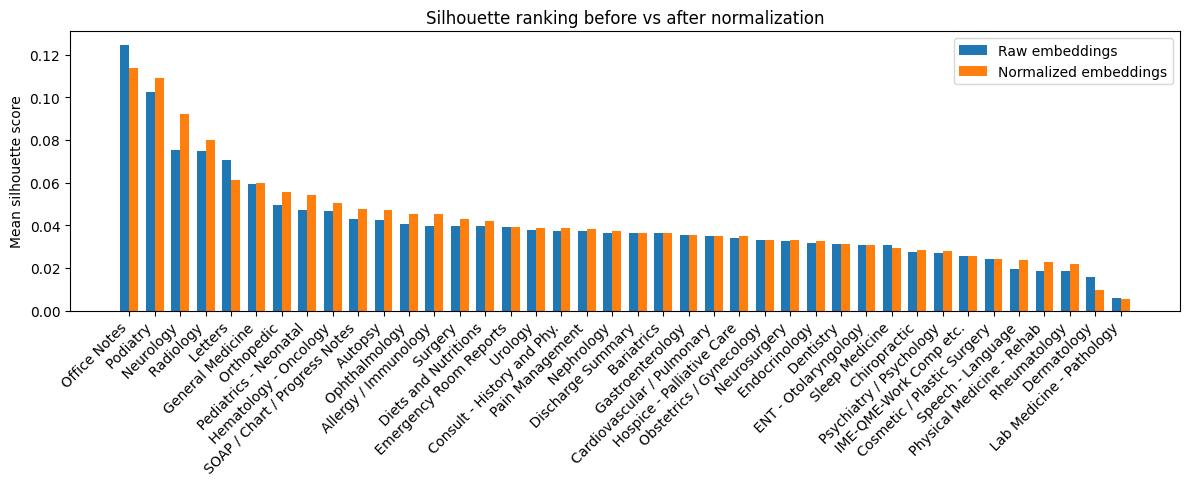

In [194]:
import numpy as np
import matplotlib.pyplot as plt

labels = top_k_df['label'].tolist()
raw_scores = top_k_df['silhouette'].tolist()
norm_scores = top_k_df_norm['silhouette'].tolist()

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, raw_scores, width, label="Raw embeddings")
plt.bar(x + width/2, norm_scores, width, label="Normalized embeddings")

plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel("Mean silhouette score")
plt.title("Silhouette ranking before vs after normalization")
plt.legend()
plt.tight_layout()
plt.show()


What we observe is that with/without normalization, the labels are ranked the same way in terms of their silhouette score. The top 4 labels are most significantly differentiated from the other labels, followed by the top 6.

We thus chose to narrow down the dataset to contain only data from the top 6 labels.

In [217]:
top_k_labels = top_k_df.index[:7].to_list()
top_k_label_names = top_k_df['label'][:7].to_list()
mask = np.isin(train_labels_enc, top_k_labels)
print("Length of dataset before: ", len(train_embeddings))
# Filter embeddings and labels
train_emb_topk = train_embeddings[mask]
train_labels_topk = train_labels_enc[mask]
print("Length after: ", len(train_emb_topk))

Length of dataset before:  3464
Length after:  856


## Top-6 vs all labels: Performance Comparison

### Baseline model (Naive Bayes)

Best performing baseline model

In [225]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import utils.task3_baseline_utils as base_utils

# Narrow down dataset to top-6 labels
mask = np.isin(np.array(train_labels), top_k_label_names)
X_train_topk = X_train_proc[mask]
print("Train size before: ", len(train_labels))
train_labels_topk = np.array(train_labels)[mask]
print("Train size after: ", len(train_labels_topk))

mask = np.isin(np.array(test_labels), top_k_label_names)
X_test_topk = X_test_proc[mask]
test_labels_topk = np.array(test_labels)[mask]

# Logistic Regression
lr = LogisticRegression(
	max_iter=1000,
	n_jobs=-1,
	class_weight="balanced"
)

lr.fit(X_train_proc, train_labels)
preds = lr.predict(X_test_proc)

base_utils.store_model_metrics_manual(
	test_labels,
	preds,
	"Task3/results/logistic_regression_topk.csv"
)

# Linear SVM
svm = LinearSVC(
	C=0.01,
	class_weight="balanced"
)

svm.fit(X_train_proc, train_labels)
preds = svm.predict(X_test_proc)

base_utils.store_model_metrics_manual(
	test_labels,
	preds,
	"Task3/results/linear_svm_topk.csv"
)

# SGD
sgd = SGDClassifier(
	loss="hinge",
	alpha=1e-2,
	max_iter=1000,
	class_weight="balanced"
)

sgd.fit(X_train_proc, train_labels)
preds = sgd.predict(X_test_proc)

base_utils.store_model_metrics_manual(
	test_labels,
	preds,
	"Task3/results/sgd_topk.csv"
)

# Naive Bayes
nb = MultinomialNB(
	alpha=0.1  # Laplace smoothing, default is fine
)
nb.fit(X_train_topk, train_labels_topk)
preds = nb.predict(X_test_topk)

base_utils.store_model_metrics_manual(
	test_labels_topk,
	preds,
	"Task3/results/naive_bayes_topk.csv"
)



Train size before:  3464
Train size after:  856


In [233]:
RESULT_PATHS = {
	"LR": "Task3/results/logistic_regression.csv",
	"LR_top_6_labels": "Task3/results/logistic_regression_topk.csv",
	"Linear SVM": "Task3/results/linear_svm.csv",
	"Linear SVM_top_6_labels": "Task3/results/linear_svm_topk.csv",
	"SGD-SVM": "Task3/results/sgd.csv",
	"SGD-SVM_top_6_labels": "Task3/results/sgd_topk.csv",
	"Naive_Bayes": "Task3/results/naive_bayes.csv",
	"Naive_Bayes_top_6_labels": "Task3/results/naive_bayes_topk.csv"

}

rows = []
for model_name, path in RESULT_PATHS.items():
	df = pd.read_csv(path)
	df["model"] = model_name
	rows.append(df)

summary_df = pd.concat(rows, ignore_index=True).set_index("model")

def highlight_max(s):
	is_max = s == s.max()
	return ['font-weight: bold' if v else '' for v in is_max]

summary_df.style.apply(highlight_max, axis=0)

,f1_weighted,accuracy,precision,recall,f1_macro
model,,,,,
LR,0.306662,0.352624,0.368757,0.352624,0.409055
LR_top_6_labels,0.306662,0.352624,0.368757,0.352624,0.409055
Linear SVM,0.312957,0.334455,0.382745,0.334455,0.342539
Linear SVM_top_6_labels,0.312957,0.334455,0.382745,0.334455,0.342539
SGD-SVM,0.248491,0.277927,0.328532,0.277927,0.283017
SGD-SVM_top_6_labels,0.248406,0.279273,0.320415,0.279273,0.280720
Naive_Bayes,0.346255,0.379542,0.363805,0.379542,0.252265
Naive_Bayes_top_6_labels,0.596702,0.602180,0.607786,0.602180,0.492965


Based on the comparison on results from all baseline models, only the multinomial Naive Bayes classification results were affected by the filtering of only the top-k labels. 

Since the clustering was performed on embeddings rather than tokens, while the baseline models were trained directly on token features, this indicates that the Naive Bayes model was capable of capturing higher-dimensional feature relationships that align with the embedding space.

The observed improvement in Naive Bayes performance suggests that classification is indeed more effective when the label set is reduced to those labels that are more clearly separable from others.

### Encoder model

### Decoder model